# **Wstęp**

Celem ćwiczenia było przygotowanie procesu, który oceni ilość jachtów w Polsce na podstawie dostępnych publicznie zdjęć satelitarnych. Projekt jest niekomercyjny i miał na celu głównie samorozwój i walidację technologii.

Opis pokazuje wszystkie kroki projektu. Natomiast jeśli chodzi o kod, to prezentuję tylko jego fragmenty dla ciekawszych i nietypowych elementów.

Przygotowanie datasetu do treningu modelu wykonałem lokalnie. Wszystkie pozostałe kalkulacje były wykonane w notatnikach Jupiter na serwisie colab.research.google.com w oparciu o darmowe środowiska. W wypadku treningu modelu lub detekcji był to T4/GPU, a dla pozostałych przetwarzań standardowe CPU. Dane przechowane są na drive.google.com.




# **Treninig modelu**

**Pozyskanie danych**

Dane do treningu modelu pozyskałem z kilku publicznych datasetów na roboflow.

Większość dostępnych danych nakierowana jest na statki, a nie jachty, więc wymagały one czyszczenia. Pozostawiłem tylko obiekty typu "Yacht","Sailboat". Wyeliminowałem zarówno okręty (klasy: "Enterprise","Atago DD","Submarine","Other Destroyer","AOE","Other Frigate","Asagiri DD","Dock") jaki i wszystkie klasy, które wskazują na większe statki ("Motorboat","Fishing Vessel","Other Ship"). Dane w roboflow niestety nie mają zdefiniowanej stałej skali, więc odrzuciłem manualnie obrazy znacząco odbiegające od średniej standardu.

Na potrzeby modelu Yolo5 należy przygotować do każdego obrazu plik *.txt z typami obiektów oraz ich położeniem na obrazie.
Dokonałem też podziału 83/17[%] (572/123) na część do treningową i walidacyjną. Z uwagi na mała próbę nie wyodrębniłem osobnej części testowej zakładając testy na realnych danych.
Ostateczne w dataset pozostało 695 obrazów. Zostały one umieszczone na roboflow  https://app.roboflow.com/grzegorz-niemczykszyszka/yachts-detect/2.

# **Trening sieci**


Model YOLO5 zawiera kilka wersji:


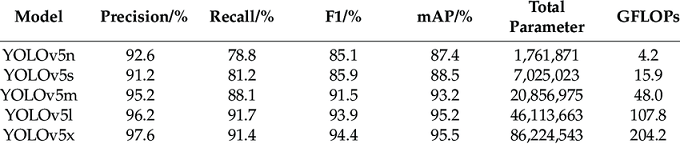



Z uwagi na uwarunkowania środowiska Colab (limit jednostek przeliczeniowych oraz 16GB pamięci GPU) i ograniczenia czasowe wybrałem model yolov5m. Mimo ograniczenia wielkości środowisko pozwalało jedynie na jednokrotne dotrenowane modelu w ciągu 12h.

Warto też zwrócić uwagę, że wszystkie wersje wykazują się bardzo wysoką precyzją, a wzrost wielkości modelu wpływa głównie na czułość.

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
!python train.py --img 840 --batch 16 --epochs 150 --data /content/drive/MyDrive/ImageDetect/train/data.yaml --weights /content/drive/MyDrive/ImageDetect/model/yolov5m.pt --cache

In [ ]:
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs

 Class     Images  Instances          P          R      mAP50   mAP50-95
   all        123        406      0.931      0.799      0.914      0.683

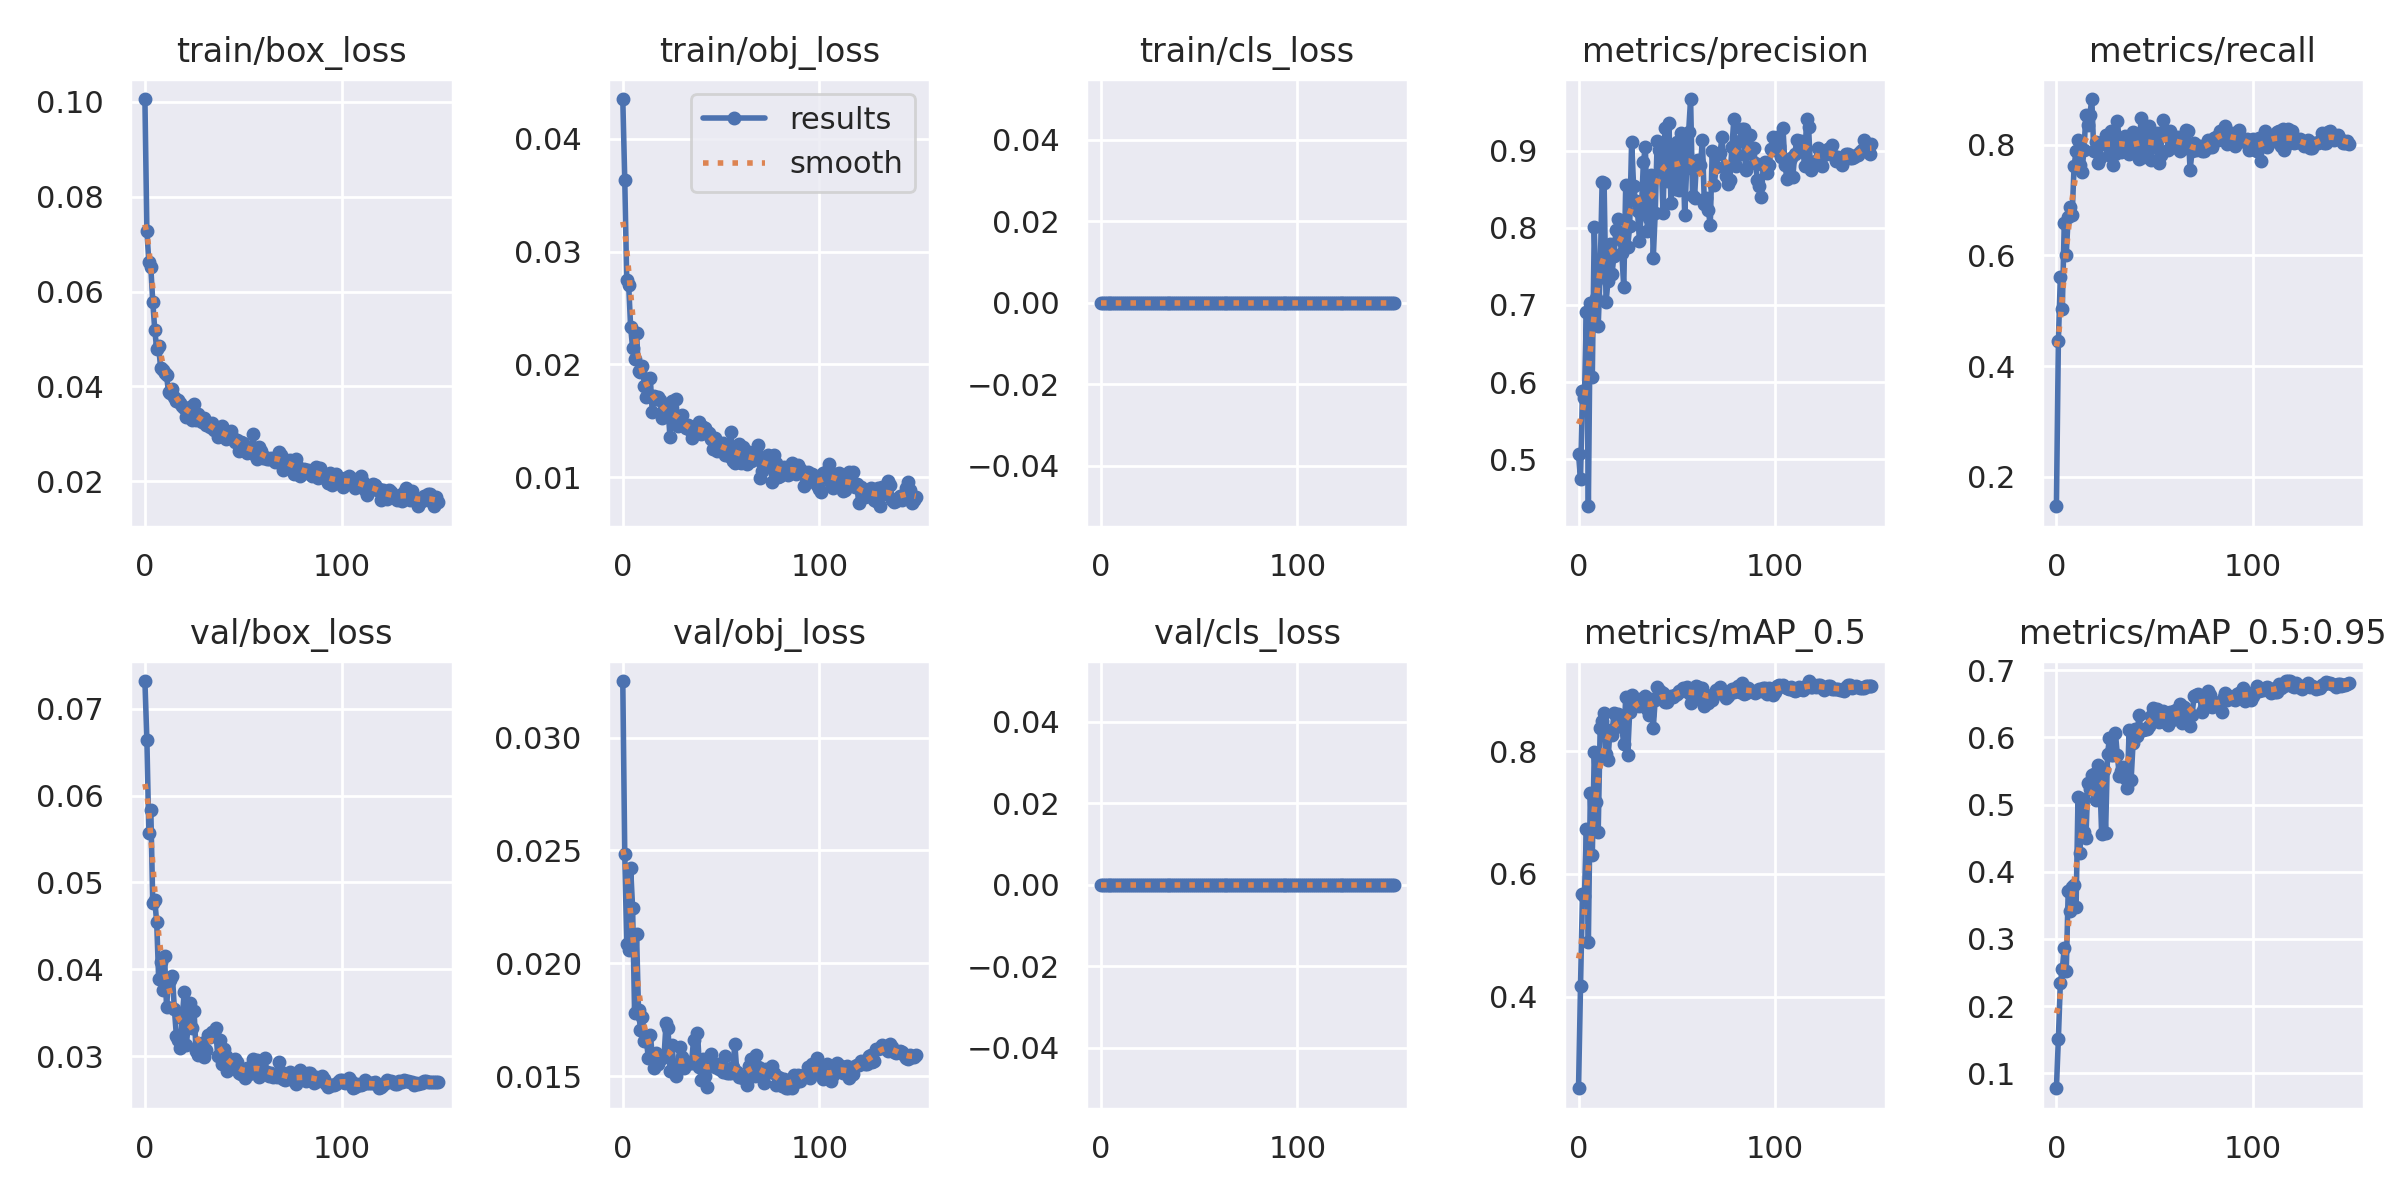

Efekty szkolenia sieci w teorii wyglądają lepiej niż można było oczekiwać po stosunkowo małej próbie szkoleniowej. Finalny trening sieci trwał mniej niż 2h. Finalny plik współczynników ma 40MB.



# **Pozyskanie danych z geoportal**

W ramach otwartych danych dobre jakościowo zdjęcia można legalnie pobierać z geoportal.gov.pl. Natomiast obszar Polski to ponad 300tyś. Km,2, czyli chcąc analizować cały kraj do pobrania było by ponad 1 milion zdjęć. W amatorskim projekcie to nieracjonalne. W celu ograniczania wolumenu danych zdecydowałem się na pobieranie zdjęć tylko z okolicy obiektów infrastruktury wodnej.

**API geoportal**

W wyniku prób na wytrenowanym wstępnie modelu oszacowałem optymalny obszar do analizy - jest kwadrat o boku w zakresie 100-150 m. Natomiast nie jest to optymalny rozmiar do pobierania z uwagi na limity zapytań do API –celowe jest ograniczenie liczby zapytań/plików. Po testach i analizie zdecydowałem się rozmiar 500 metrów oraz rozdzielczość 2500 pikseli . Limity API nie są jawne, ale występują. Po kilkuset zdjęciach połączenie jest zrywane. Wprawdzie wystarczy proste zabezpieczenie przechwytujące błąd ze zwiększeniem czasu oczekiwania, ale zmniejsza to szybkość pobierania danych.

Wymagane jest także proste przybliżenie podczas konwersji różnicy w pozycji geograficznej (lat/lon) na metry. Dla uproszczenia przyjąłem stałe współczynniki, które są odpowiednie dla północy Polski. W celu zwiększenia dokładności proporcji można dodać relatywną kalkulację w zależności od pozycji. Natomiast z uwagi, że obrazy są jedynie wtórnym efektem rozwiązania, nie zdecydowałem się na rozbudowę – skomplikowało by to niepotrzebnie rozwiązanie.



In [ ]:
import requests

URL = "https://mapy.geoportal.gov.pl/wss/service/PZGIK/ORTO/WMS/StandardResolution"

file_size = 840*4
step = 500

lat_m_size,lon_m_size = 1/111000.0, 1/70000.0

gps_step_lat = round(lat_m_size * step, 4)
gps_step_lon = round(lon_m_size * step, 4)

def get_img(lat, lon, step_size):
    attempts = 10
    place = str(round(lon-gps_step_lon/2, 6))+","+str(round(lat-gps_step_lat/2, 6)) + \
        ","+str(round(lon+gps_step_lon/2, 6))+"," + \
        str(round(lat+gps_step_lat/2, 6))

    PARAM = {"request": "getmap",
             "version": "1.1.1",
             "service": "WMS",
             "srs": "EPSG:4326",
             "format": "image/png",
             "bbox": str(place),
             "width": str(file_size),
             "height": str(file_size),
             "styles": "",
             "layers": "raster"}

    for attempt in range(attempts):
        try:
            r = requests.get(url=URL, params=PARAM, timeout=60)
            if r.status_code == 200:
                return Image.open(BytesIO(r.content))
        except Exception as e:
            print(f"Attempt {attempt + 1} failed. Error: {e}")
            time.sleep(attempt)

    raise Exception("Failed to retrieve image after 10 attempts.")

**OSM OpenStreetMap**

Po wybraniu wielkości obszaru do pobrania z GeoPortalu można szybko oszacować, że cała Polska to ponad 500GB danych. Przy bardzo optymistycznym założeniu wydajności, 1sek na plik, to 14 dni pobierania obrazów .

W celu ograniczenia ilości danych zdecydowałem się na przeprowadzenie analizy dla obszarów dookoła infrastruktury wodnej. Łatwe wyszukanie tej infrastruktury jest możliwe za pomocą API do OSM (Open Street Map).
Zapytania do OSM są generowanie są przy użyciu OSM Queries. Dokumentacja jest dostępna tu:: [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_API_by_Example)

Tu natomiast jest GUI które znacznie ułatwia testowanie zapytań:
[overpass turbo](https://overpass-turbo.eu/
)

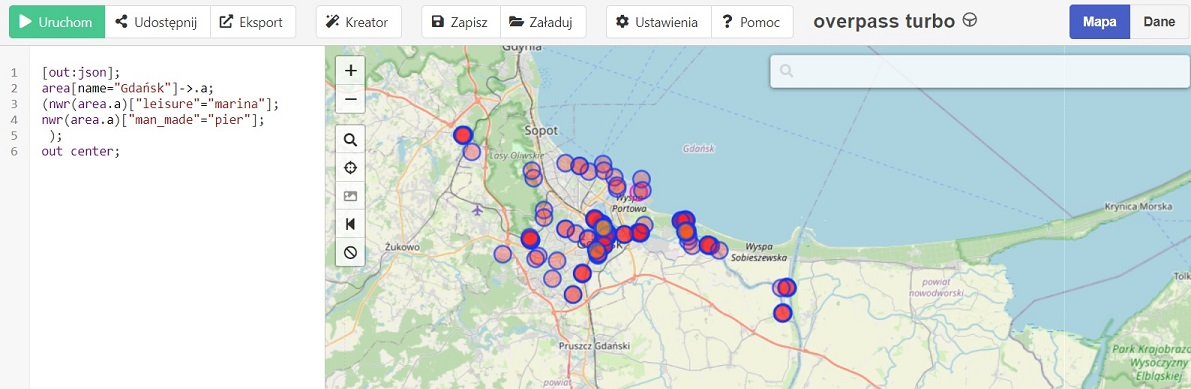

Przykładowe zapytanie wygląda następująco:

In [ ]:
[out:json];
area[name="Polska"]->.a;
(nwr(area.a)["leisure"="marina"];
nwr(area.a)["man_made"="pier"];
nwr(area.a)["seamark:type"="harbour"];
 );
out center;

A tu kod a python pobierający dane:

In [ ]:
result = api.query("""[out:json]; \
area[name="Polska"]->.a; \
(nwr(area.a)["leisure"="marina"]; \
 nwr(area.a)["man_made"="pier"]; \
 nwr(area.a)["seamark:type"="harbour"]; \
 ); \
out center;""")
for node in result.nodes:
    list_points.append((float(node.lat), float(node.lon), node.tags.get("name", "non")))

for way in result.ways:
    list_points.append((float(way.center_lat), float(way.center_lon), way.tags.get("name", "non")))

for relation in result.relations:
    list_points.append((float(relation.center_lat), float(relation.center_lon), relation.tags.get("name", "non")))

W praktyce otrzymałem **15104**  obiektów, na które składają się:

Mariny: **828** / Porty: **707**  / Pomosty: **14217**


**Podział Polski na jednolite boxy**

Obiekty czasami pokrywają się i często są bardzo blisko siebie. W związku z tym przyjąłem stałą siatkę interpolując punkty do stałego rastra wielkości 500m. Dzięki temu uzyskałem listę punktów oraz środki kwadratów siatki, w których się one znajdują.

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    a = sin(delta_lat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(delta_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c * 1000

    return distance

def find_square(latitude, longitude):
    meters_per_degree_lat = 111000.0
    meters_per_degree_lon = 70000.0

    shift_lat = round(500 / meters_per_degree_lat,6)
    shift_lon = round(500 / meters_per_degree_lon,6)

    square_center_lat  = round(math.floor(latitude / shift_lat) * shift_lat, 6)
    square_center_lon  = round(math.floor(longitude / shift_lon) * shift_lon, 6)

    possible_centers = [
        (square_center_lat, square_center_lon),
        (round(square_center_lat + shift_lat, 6), square_center_lon),
        (round(square_center_lat - shift_lat, 6), square_center_lon),
        (square_center_lat, round(square_center_lon + shift_lon, 6)),
        (square_center_lat, round(square_center_lon - shift_lon, 6))
    ]

    closest_center = None
    min_distance = float('inf')

    for center in possible_centers:
        distance = calculate_distance(center[0],center[1],latitude,longitude)

        if distance < min_distance:
            min_distance = distance
            closest_center = center

    return closest_center

**Obiekty na krawędzi**

Po wzbogaceniu wyników o punkty środkowe (przywiązanie ich do stałej siatki 500m) okazało się, że obiekty często znajdują się na krawędzi obrazu lub bardzo jej blisko. Dodatkowo jachty często znajdowały się obok pomostu/mariny, a nie w obrębie obiektu zdefiniowanego w OSM. Stąd przyjąłem, że jeśli obiekt znajduje się mniej niż 100m od krawędzi, pobieram także sąsiadujące kwadraty (w wypadku narożnika wszystkie trzy).

Wygląda to mniej więcej następująco:

In [ ]:
if lat_m < -broder_idx:
   lat_diff = round(float(point[0]) - 500 * (1/meters_per_degree_lat),6)
     if lon_m < -broder_idx:
        lon_diff = round(float(point[1]) - 500 * (1/meters_per_degree_lon),6)
        ps = find_square(lat_diff,lon_diff)
        list_points_square.append((ps[0],ps[1],point[2]))

Finalnie po dodaniu obrazów dla punktów przy krawędziach oraz deduplikacji do analizy pozyskałem nieco ponad **9000** plików.

**OSM Nominiation**

W celu określenia podstawowych danych adresowych używam prostej biblioteki Nominatim. Pozwala ona na pobranie szerokiego zakresu danych o lokalizacji.

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(timeout=30, user_agent="GeocoderForSips")

location = geolocator.reverse((lat_point, lon_point))
address = location.raw['address']

postcode = address.get('postcode', '')
city = address.get('city', '')
town = address.get('town', '')
village = address.get('village', '')
county = address.get('county', '')
suburb = address.get('suburb', '')
municipality = address.get('municipality', '')
district = address.get('district', '')

**Zapis już pozyskanych obszarów**


Pozyskane obrazy zapisuję do pliku z podstawowymi danymi w nazwie. Z perspektywy czasu wystarczające byłyby lat i lon oraz wielkość obszaru. Ale dodatkowo mam także kod pocztowy, adres oraz nazwę obiektu jeśli wstępuje.

Dodatkowo w prostym obiekcie json zapisuję koordynaty już pobranych plików, w celu uniknięcia ponownego zapisania tych samych obszarów.


In [ ]:
img.save(project_path + f"/{adr_str}_{desc}_{step}_{lat_point}_{lon_point}.jpg")
db.add_point(lat_point, lon_point)

**Podsumowanie pozyskania obrazów do detekcji**

Czasowo pobranie obrazów źródłowych zajęło najwięcej czasu w całym ćwiczeniu. Trudno oszacować ile było to dokładnie, bo był to proces rozciągnięty w czasie. Myślę że gdyby trwało to non-stop, to by zajęło ponad 36h. Pobrane pliki zajmują niecałe 10GB.

# **Detekcja**

Pobrane z GeoPortal pliki mają rozmiar znacznie większy niż te, na których był szkolony model. Jak pisałem wcześniej, próby wykazały, że detekcja na niepodzielonym pliku jest znacznie mniej czuła niż analiza fragmentów i scalenie obrazu po detekcji. Poniżej główna pętla, która pobiera kolejne pliki z katalogu i następnie dzieli obraz na fragmenty zbliżone rozmiarem do tych z treningu modelu. Przed ponownym scaleniem danych istotne jest przeliczenie przesunięcia detekcji, żeby po połączeniu pliku pokazywać obiekty z właściwego fragmentu.


In [ ]:
processed_files = set()

if os.path.exists(list_processed_files):
    with open(list_processed_files, 'r') as lstfile:
        file_content = lstfile.read().strip()
        if file_content:
            processed_files = set(json.loads(file_content))

files = os.listdir(input_path)
for file in files:
    if file.endswith(".tif") or file.endswith(".jpg") or file.endswith(".bmp"):
        if file not in processed_files:
            input_file_path = os.path.join(input_path, file)

            object_in_file = 0
            print(Path(file).stem)
            with Image.open(input_file_path) as img:
                detections = []
                width, height = img.size
                print(img.size)
                if width > detection_crop_size or height > detection_crop_size:
                    num_slices_w = (width // detection_crop_size) + 1
                    num_slices_h = (height // detection_crop_size) + 1
                    for i in range(num_slices_w):
                        for j in range(num_slices_h):
                            slice_detections =[]
                            start_pixel_w = i * detection_crop_size
                            start_pixel_h = j * detection_crop_size
                            end_pixel_w = min((i + 1) * detection_crop_size, width)
                            end_pixel_h = min((j + 1) * detection_crop_size, height)
                            slice_img = img.crop((start_pixel_w, start_pixel_h, end_pixel_w, end_pixel_h))
                            output_file_path = os.path.join(output_path, Path(file).stem + "_" + str(i) + "_" + str(j) + ".jpg")
                            slice_detections = detect_in_file(slice_img, output_file_path)
                            object_in_file += len(slice_detections)

                            detection =[]
                            for detection in slice_detections:
                                detection["xmin"] += start_pixel_w
                                detection["ymin"] += start_pixel_h
                                detection["xmax"] += start_pixel_w
                                detection["ymax"] += start_pixel_h

                            detections.extend(slice_detections)
                else:
                    output_file_path = os.path.join(output_path, Path(file).stem + ".jpg")
                    detections = detect_in_file(img, output_file_path)
                    object_in_file = len(detections)

                print(Path(file).stem,object_in_file)

                output_file_path = os.path.join(output_path, Path(file).stem + ".jpg")
                object_in_total += object_in_file

                print(Path(file).stem + ": " + str(object_in_file))

                if len(detections) >0:
                    mark_object_on_image(img,output_file_path,detections)
                    save_detections(detections, input_file_path, img, output_file_path)

                processed_files.add(file)

                with open(list_processed_files, 'w') as lstfile:
                    json.dump(list(processed_files), lstfile)

**Funkcja do detekcji**

Same wywołanie detekcji jest trywialne. To po prostu inicjalizacja modelu i wywołanie detekcji. W wyniku szklenia widać że model jest bardzo dokładny ale me pewne problemy z czułością. Z tego powodu ustawiłem niski próg pewności oznaczania obiektó1). W wynikach zapisuje prawdopodobieństwo poprawności detekcji w celu umożliwienia dobrania finalnego progu w etapie analizy danych.



In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', 'ships_yolo5m_840best.pt')
model.conf = 0.35

def detect_in_file(detect_imgs, output_file):
    results  = model(detect_imgs,size=840)

    detect_detection =[]
    detect_detections =[]
    for detect_detection in results.xyxy[0].cpu().numpy():
      result = {
        'name': model.names[int(detect_detection[5])] if model.names else f'Class {int(detect_detection[5])}',
        'confidence': float(detect_detection[4]),
        'xmin': float(detect_detection[0]),
        'ymin': float(detect_detection[1]),
        'xmax': float(detect_detection[2]),
        'ymax': float(detect_detection[3])
        }
      detect_detections.append(result)

    return detect_detections

In [ ]:
Adding AutoShape...
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-1-6 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
yacht  :  0.9412184357643127  :  203.20587158203125 ,  580.2990112304688 ,  253.2606201171875 ,  608.0307006835938
yacht  :  0.897368311882019  :  69.39605712890625 ,  550.1399536132812 ,  121.4238510131836 ,  585.6398315429688
yacht  :  0.6368836164474487  :  708.2369384765625 ,  12.198528289794922 ,  739.896728515625 ,  55.18220901489258
yacht  :  0.6005674004554749  :  431.406982421875 ,  421.5692138671875 ,  457.7014465332031 ,  470.75250244140625
object_in_file 81-198_gmina Kosakowo_Rewa_przystań rybacka Rewa II_500_54.632135_18.507513_2_0 4
Fusing layers...
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

**Oznaczanie detekcji na obrazach**

W celu wizualnej weryfikacji wszystkie detekcje są zapisywane także jako obrazy z oznaczonymi jachtami. Dodatkowo zapisana jest długość jednostek oraz ich ilość na obrazie. Nieco zabawy wymagało znalezienie czcionek dostępnych w colab oraz rysowanie prostokątów i naniesienie podpisów.

In [ ]:
def mark_object_on_image(mooi_input_image, mooi_output_file, mooi_detections):
    line_width = 2
    ft_size = 20
    font_box = ImageFont.truetype(r'/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', ft_size)
    font_total = ImageFont.truetype(r'/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',int(min(mooi_input_image.size) * 0.05))
    if len(mooi_detections) > 0:
        mooi_img = mooi_input_image.copy()
        draw = ImageDraw.Draw(mooi_img)

        mooi_detection =[]
        for mooi_detection in mooi_detections:
            name = mooi_detection["name"]
            confidence = float(mooi_detection["confidence"])*100

            x1, y1, x2, y2 = mooi_detection['xmin'],mooi_detection['ymin'],mooi_detection['xmax'],mooi_detection['ymax']
            size_px = max(abs(x2-x1),abs(y2-y1))
            w,h = mooi_img.size
            size_m = int(size_px * (500.0/h))
            draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=line_width)
            draw.text((x1, y1 - ft_size - line_width), f"{int(confidence)}%,{size_m}m",fill="red", font=font_box)

        draw.text((15, 90 ), f"ships: {str(len(mooi_detections))}",fill="red", font=font_total)
        mooi_img.save(mooi_output_file)

**Zapis do plików csv**

Przed zapisem wyników do pliku, należy dokonać obliczeń i przekształcenia pikseli na współrzędne geograficzne. Zapis parametrów w nazwie pliku ułatwia mi znacznie to zadanie. Dzięki zastosowaniu tego samego skalowania stopni na metry, odwracam potencjalne niewielkie zniekształcenia proporcji wprowadzone przy pobieraniu zdjęć.

In [ ]:
def save_detections(sd_detections, input_file, sd_img, output_file):
    name, ext = os.path.splitext(os.path.basename(input_file))
    parts = name.split("_")
    if len(parts)>5:
        post_code = parts[0]
        name = parts[1]
        subname = parts[2]
        loctation = parts[3]
        step = int(parts[4])
        lat = float(parts[5])
        lon = float(parts[6])

        w,h = sd_img.size
        px_lat, px_lon = calc_px_size(step, int(w))
        SW_corner_lat = round(lat - (px_lat * (w/2)),4)
        SW_corner_lon = round(lon - (px_lon * (w/2)),4)

        output_file_path = os.path.join(output_path_txt, Path(output_file).stem + ".csv")

        with open(output_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            no = 0
            writer.writerow(["no", "lat","lon","post_code", "name", "subname", "loctation",  "desc", "probability","size"])
            for sd_detection in sd_detections:
                no = no + 1
                x = sd_detection['xmin'] + (sd_detection['xmax'] - sd_detection['xmin'])/2
                y = sd_detection['ymin'] + (sd_detection['ymax'] - sd_detection['ymin'])/2
                point_lat = round(SW_corner_lat + (w-y) * px_lat,4)
                point_lon = round(SW_corner_lon + x * px_lon,4)
                desc = name + " " + subname + " no" + str(no)
                x1, y1, x2, y2 = sd_detection['xmin'],sd_detection['ymin'],sd_detection['xmax'],sd_detection['ymax']
                size_px = max(abs(x2-x1),abs(y2-y1))
                size_m = int(size_px * (500.0/h))
                writer.writerow([no, point_lat, point_lon, post_code, name, subname, loctation, desc, sd_detection["confidence"], size_m])
        file.close()

Kilka przykładowych obrazów wynikowych

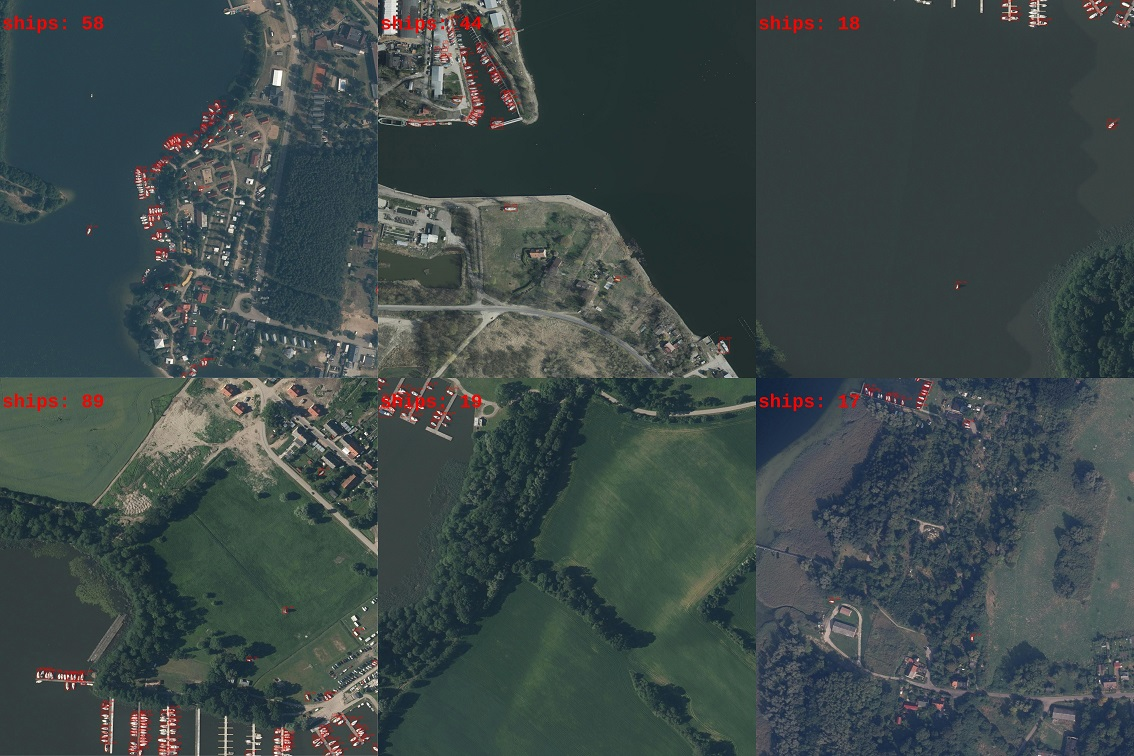

Sumarycznie cała detekcja zajęła około 24h. Natomiast nie jest możliwe jej jednorazowe przeprowadzenie w darmowej wersji Collab. Ograniczeniem jest limit środowiska GPU - w ciągu doby w praktyce dostępne jest tylko kilka godzin darmowego GPU.

# **Wzbogacene danych**

Podczas detekcji dokonałem zapisu wyników do plików csv dla każdego z obrazów, gdzie wykryto jacht.

**Scalenie danych**

Pierwszym krokiem było scalenie w formacje json.

In [ ]:
data = []

for root, dirs, files in os.walk(output_path_txt):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                lines = file.readlines()
                df = pd.read_csv(file_path)
                df['file_name'] = file_name
                data.append(df)

merged_df = pd.concat(data)
merged_df.to_json(terget_file, orient='records')

**Pozyskanie danych z Nomination**

Ponieważ detekcje były przesunięte w stosunku do środka obrazu, w kolejnym kroku dokonałem aktualizacji danych z Nomination.


In [ ]:
def reverse_geocode(row):
    location = geolocator.reverse((row['lat'], row['lon']))
    address = location.raw['address']
    address_dict = {
        'lat': row['lat'],
        'lon': row['lon'],
        'loctation': row['loctation'],
        'probability': row['probability'],
        'size': row['size'],
    }
    for key, value in address.items():
        address_dict[key] = value
    return address_dict

reverse_geocoded_data = merged_df.apply(reverse_geocode, axis=1)
reverse_geocoded_df = pd.DataFrame(reverse_geocoded_data.tolist())

**Pozyskanie nazwy zbiornika i mariny z OSM**

W danych brakuje informacji czy jacht jest w marnie/porcie lub w jej pobliżu. W celu pozyskania tych danych najwygodniejsze jest sprawdzenie czy jesteśmy wewnątrz obiektu w OSM ( funkcja is_in). Natomiast często mariny są oznaczone po obrysie pomostów lub lingi brzegowej. Stąd poszukuję, czy nie ma obiektu w odległości do 200m (iteracyjnie co 20m). Identycznie postępuję dla zbiorników wodnych zmieniając tylko typ wyszukiwanych obiektów w OSM.

Dla zbiorników wodnych wygląda to następująco:

In [ ]:
["water"="river"]
["waterway"="river"]
["waterway"="canal"]
["natural"="bay"]
["natural"="water"]

I cała funkcja

In [ ]:
def search_water_info(lat, lon):
    name = ''
    distance = 0

    result = api.query(f'''
        [out:json][timeout:25];
        is_in({lat},{lon});
        area._["natural"="water"];
        out body;
        is_in({lat},{lon});
        area._["natural"="bay"];
        out body;
        is_in({lat},{lon});
        area._["waterway"="canal"];
        out body;
        is_in({lat},{lon});
        area._["water"="river"];
        out body;
        is_in({lat},{lon});
        area._["waterway"="river"];
        out body;
    ''')

    if len(result.areas) > 0:
        if 'name:pl' in result.areas[0].tags:
            name = result.areas[0].tags["name:pl"]
        else:
            name = result.areas[0].tags["name"]

    while name == '' and distance < 200:
        distance = distance + 20
        result = api.query(f'''
            [out:json][timeout:25];
            (
            nwr["water"="river"][name](around:around:{distance},{lat},{lon});
            nwr["waterway"="river"][name](around:around:{distance},{lat},{lon});
            nwr["waterway"="canal"][name](around:around:{distance},{lat},{lon});
            nwr["natural"="bay"][name](around:around:{distance},{lat},{lon});
            nwr["natural"="water"][name](around:around:{distance},{lat},{lon});
            );
            out body;
            ''')

        if len(result.ways) > 0:
            if 'name:pl' in result.ways[0].tags:
                name = result.ways[0].tags["name:pl"]
            else:
                name = result.ways[0].tags["name"]

        if len(result.relations) > 0:
            if 'name:pl' in result.relations[0].tags:
                name = result.relations[0].tags["name:pl"]
            else:
                name = result.relations[0].tags["name"]

        if len(result.nodes) > 0:
            if 'name:pl' in result.nodes[0].tags:
                name = result.nodes[0].tags["name:pl"]
            else:
                name = result.nodes[0].tags["name"]

        distance = distance + 10

    if len(name)>0:
      print(name,distance)
      return name
    else:
      return None


Filtry dla marin:

In [ ]:
["leisure"="marina"]
["industrial"="port"]
["seamark:type"="harbour"]

Pierwsze podejście zrobiłem za pomocą apply, ale to rozwiązanie nie było odporne na zrywanie połączenia, więc z niego zrezygnowałem na rzecz klasycznej pętli.

In [ ]:
for index, row in df.iterrows():
    if 'osm_check' not in row or row['osm_check'] != 'ok':
        df.at[index, 'osm_leisure'] = search_location_info(row['lat'], row['lon'])
        df.at[index, 'osm_water'] = search_water_info(row['lat'], row['lon'])
        df.at[index, 'osm_check'] = 'ok'

Następnie dodałem hierarchę wyboru miejsca według tej kolejności:

1) Nazwa OSM z punktu

2) Nazwa OSM z otoczenia 200m

3) Nazwa z Nomination wg. kolejności leisure -> industrial -> club -> man_made -> emergency -> tourism -> building

4) Nazwa z pliku


#Statystki

Na koniec przejrzałem statystki kolumn i usunąłem kolumny z danymi adresowymi o niskim stopniu wypełnienia i nie mające większej wartości. Scaliłem także pola opisujące  powiat i miasta na prawach powiatu, oraz gminę z nazwą miast w celu łatwiejszej hierarchizacji danych.

Na końcu przygotowałem prosty export do JSON i import do Excela w zakresie:
województwo powiat (powiat lub miasto na prawach powiatu), gmina (gmina lub miasto), loc1 (wieś, dzielnica), loc2 (osada, osiedle), kod, akwen (jezioro, rzeka, zalew, zatoka, kanał), obiekt (marina, port, klub), probability (prawdopodobieństwo z modelu i w zaokrągleniu),size (rozmiar w metrach), lat, lon, img_link (link go miejsca w geoportal)

Dane dostępne są w załączniku.



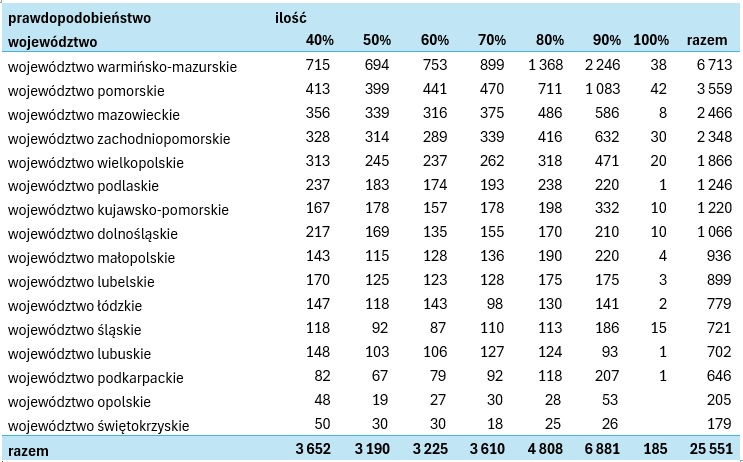


# **Podsumowanie**

Pomimo kilku trudności efekt ćwiczenia spełnił większość oczekiwań. Wyniki wyglądają wartościowo i można z nich wyciągnąć sporo ciekawych statystyk.
Największym ograniczeniem całego pomysłu jest pora roku i aktualność danych źródłowych. Wschodnia cześć kraju ma w geoportal dane z lata 2022 i są one bardzo dobrej jakości. Natomiast w zachodniej części kraju większość zdjęć pochodzi z lat 2021 -2022 i do tego najczęściej jest to wczesna wiosna lub późna jesień (kolory/brak liści). Powoduje to z pewnością zaniżenie ilości wykrywanych jachtów.

Kolejną słabością były dane do szkolenie modelu. Ilość jachtów w marinach była w nich mała, a tych na lądzie wręcz radykalnie mała. Znaczne pogorszyło to zdolność modelu do detekcji jachtów na brzegu – co było istotne szczególnie w danych z zachodniej części kraju.

Zastrzegam użycie opracowania i danych jedynie do celów niekomercyjnych. W razie pytań zapraszam do kontaktu.


W razie pytań zaprasam go kontaktu.

Grzegorz Niemczyk-Szyszka

gniemczykszyszka@gmail.com



